In [67]:
"""https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset/notebook
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [68]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')

PassengerId = test_df['PassengerId']

print(train_df.shape, test_df.shape)

test_df.head(3)

(891, 12) (418, 11)


PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   
2          894       2         Myles, Mr. Thomas Francis    male  62.0      0   

   Parch  Ticket    Fare Cabin Embarked  
0      0  330911  7.8292   NaN        Q  
1      0  363272  7.0000   NaN        S  
2      0  240276  9.6875   NaN        Q

In [69]:
orig_train_df = train_df.copy()

full_data = [train_df, test_df]

train_df['HasCabin'] = train_df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test_df['HasCabin'] = test_df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].fillna('S').map({'S':0, 'C':1, 'Q':2, }).astype(int)
    
    # Mapping Fare
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())    
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

In [70]:
train_df = train_df.drop([
    'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',
], axis=1)
train_df.head()

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  HasCabin
0         0       3    1    1      0     0         0         0
1         1       1    0    2      0     3         1         1
2         1       3    0    1      0     1         0         0
3         1       1    0    2      0     3         0         1
4         0       3    1    2      0     1         0         0

In [73]:
test_df = test_df.drop([
    'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',
], axis=1)
test_df.head()

Pclass  Sex  Age  Parch  Fare  Embarked  HasCabin
0       3    1    2      0     0         2         0
1       3    0    2      0     0         0         0
2       2    1    3      0     1         2         0
3       3    1    1      0     1         0         0
4       3    0    1      1     1         0         0

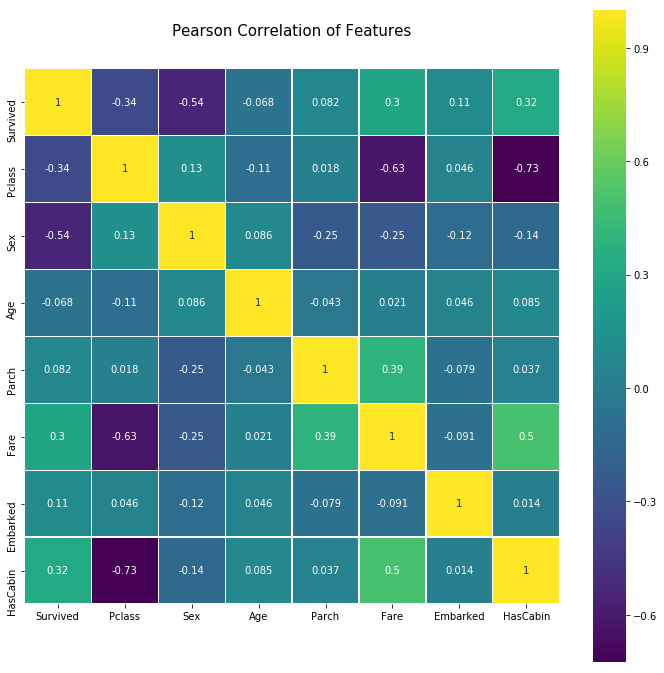

In [74]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [75]:
len(test_df.columns)

7

In [77]:
y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis=1).values
X_test = test_df.values

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# pd.DataFrame({
#     'PassengerId': PassengerId,
#     'Survived': y_pred,
# })

acc_decision_tree = round(model.score(X_train, y_train) * 100, 2)
acc_decision_tree

88.549999999999997

In [82]:
train_df.head()

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  HasCabin
0         0       3    1    1      0     0         0         0
1         1       1    0    2      0     3         1         1
2         1       3    0    1      0     1         0         0
3         1       1    0    2      0     3         0         1
4         0       3    1    2      0     1         0         0

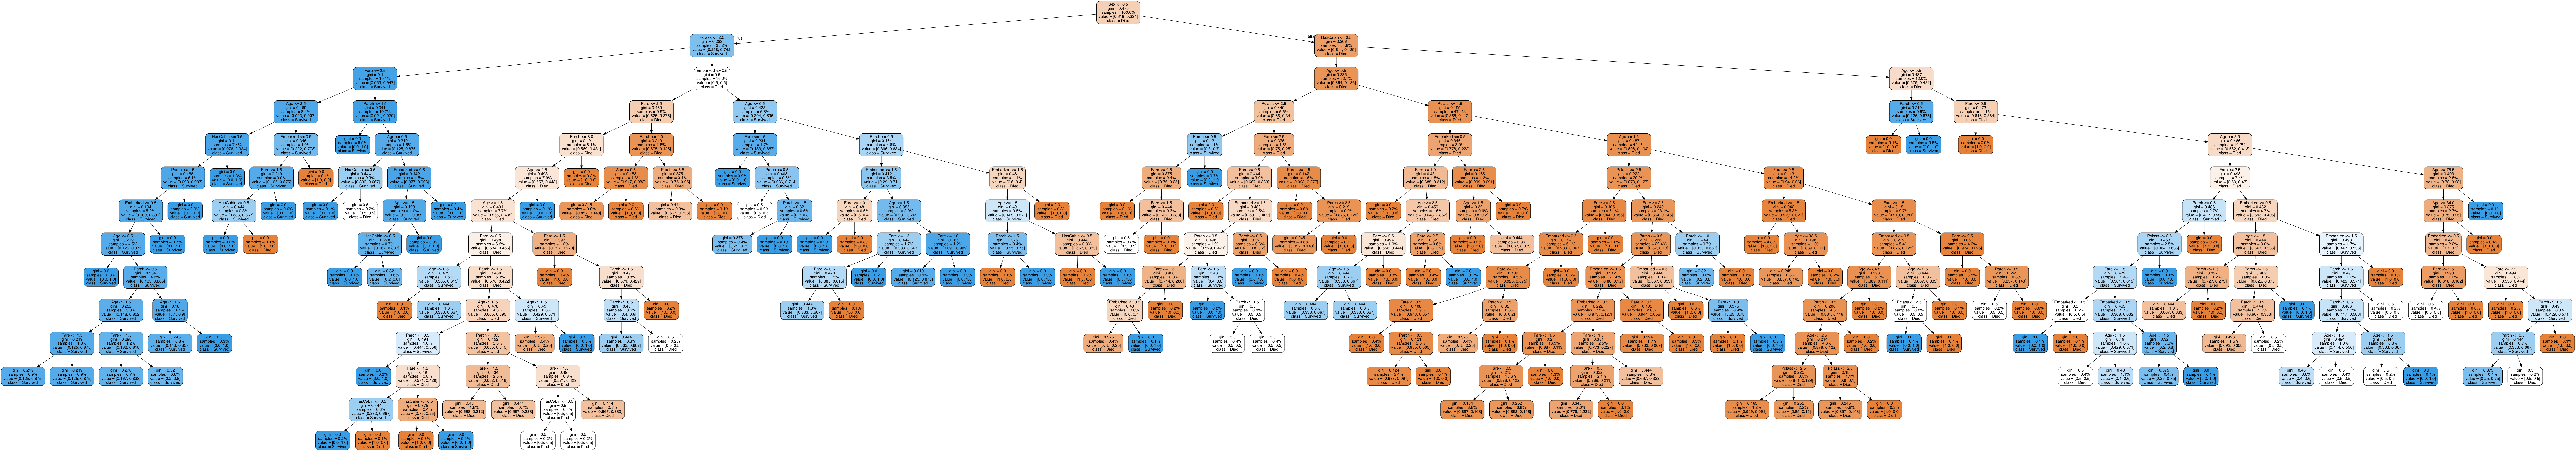

In [81]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot_ng

dot_data = StringIO()
export_graphviz(model, 
                out_file=dot_data, 
                feature_names=train_df.drop('Survived', axis=1).columns,
                class_names=['Died', 'Survived'],
                filled=True,
                rounded=True,
                proportion=True,
               )
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [84]:
model.tree_.node_count

301

In [124]:
# pd.DataFrame([
#     left,
#     right,
# ]).T

In [108]:
left = model.tree_.children_left
left

array([  1,   2,   3,   4,   5,   6,   7,   8,  -1,  10,  11,  12,  -1,
        -1,  15,  -1,  -1,  18,  -1,  -1,  -1,  -1,  -1,  24,  25,  26,
        -1,  -1,  -1,  -1,  31,  -1,  33,  34,  -1,  -1,  37,  38,  39,
        -1,  -1,  -1,  -1,  44,  45,  46,  47,  48,  49,  50,  -1,  -1,
        53,  54,  55,  -1,  57,  58,  -1,  -1,  61,  -1,  -1,  64,  65,
        -1,  -1,  68,  69,  -1,  -1,  -1,  73,  -1,  -1,  76,  -1,  78,
        79,  -1,  -1,  -1,  -1,  -1,  85,  86,  -1,  -1,  89,  -1,  -1,
        92,  93,  -1,  95,  -1,  97,  -1,  -1, 100, 101, 102,  -1,  -1,
       105, 106, 107,  -1,  -1,  -1, 111,  -1,  -1, 114, 115, 116,  -1,
        -1, 119,  -1,  -1,  -1, 123, 124, 125, 126, 127,  -1, 129,  -1,
        -1,  -1, 133, 134,  -1, 136, 137, 138, 139,  -1,  -1,  -1, 143,
        -1, 145,  -1,  -1, 148,  -1,  -1, 151,  -1, 153,  -1,  -1, 156,
       157, 158,  -1, 160, 161, 162,  -1,  -1,  -1, 166,  -1,  -1, 169,
       170,  -1,  -1,  -1, 174, 175, 176, 177, 178, 179,  -1, 18

In [109]:
right = model.tree_.children_right
right

array([122,  43,  30,  23,  22,  21,  20,   9,  -1,  17,  14,  13,  -1,
        -1,  16,  -1,  -1,  19,  -1,  -1,  -1,  -1,  -1,  29,  28,  27,
        -1,  -1,  -1,  -1,  32,  -1,  36,  35,  -1,  -1,  42,  41,  40,
        -1,  -1,  -1,  -1,  91,  84,  83,  82,  75,  52,  51,  -1,  -1,
        72,  63,  56,  -1,  60,  59,  -1,  -1,  62,  -1,  -1,  67,  66,
        -1,  -1,  71,  70,  -1,  -1,  -1,  74,  -1,  -1,  77,  -1,  81,
        80,  -1,  -1,  -1,  -1,  -1,  88,  87,  -1,  -1,  90,  -1,  -1,
        99,  94,  -1,  96,  -1,  98,  -1,  -1, 113, 104, 103,  -1,  -1,
       110, 109, 108,  -1,  -1,  -1, 112,  -1,  -1, 121, 118, 117,  -1,
        -1, 120,  -1,  -1,  -1, 242, 155, 132, 131, 128,  -1, 130,  -1,
        -1,  -1, 150, 135,  -1, 147, 142, 141, 140,  -1,  -1,  -1, 144,
        -1, 146,  -1,  -1, 149,  -1,  -1, 152,  -1, 154,  -1,  -1, 173,
       168, 159,  -1, 165, 164, 163,  -1,  -1,  -1, 167,  -1,  -1, 172,
       171,  -1,  -1,  -1, 213, 188, 187, 186, 183, 180,  -1, 18

In [90]:
model.tree_.feature

array([ 1,  0,  4,  2,  6,  3,  5,  2, -2,  3,  2,  4, -2, -2,  4, -2, -2,
        2, -2, -2, -2, -2, -2,  5,  4,  6, -2, -2, -2, -2,  3, -2,  2,  6,
       -2, -2,  5,  2,  6, -2, -2, -2, -2,  5,  4,  3,  2,  2,  4,  2, -2,
       -2,  3,  2,  3, -2,  4,  6, -2, -2,  6, -2, -2,  3,  4, -2, -2,  4,
        6, -2, -2, -2,  2, -2, -2,  4, -2,  3,  3, -2, -2, -2, -2, -2,  3,
        2, -2, -2,  3, -2, -2,  2,  4, -2,  3, -2,  3, -2, -2,  3,  5,  4,
       -2, -2,  2,  4,  4, -2, -2, -2,  4, -2, -2,  5,  2,  3, -2, -2,  6,
       -2, -2, -2,  6,  2,  0,  3,  4, -2,  4, -2, -2, -2,  4,  4, -2,  5,
        3,  4,  5, -2, -2, -2,  4, -2,  3, -2, -2,  3, -2, -2,  3, -2,  3,
       -2, -2,  0,  5,  4, -2,  2,  4,  2, -2, -2, -2,  4, -2, -2,  4,  2,
       -2, -2, -2,  2,  0,  4,  5,  4,  4, -2,  3, -2, -2,  3, -2, -2, -2,
       -2,  4,  3,  5,  5,  4,  4, -2, -2, -2,  4,  4, -2, -2, -2,  4, -2,
       -2,  5, -2,  4, -2, -2,  3, -2, -2,  4,  5, -2,  2, -2, -2,  4,  5,
        2,  3,  2,  0, -2

In [126]:
features

['Sex',
 'Pclass',
 'Fare',
 'Age',
 'HasCabin',
 'Parch',
 'Embarked',
 'Age',
 'Embarked',
 'Parch',
 'Age',
 'Fare',
 'Embarked',
 'Embarked',
 'Fare',
 'Embarked',
 'Embarked',
 'Age',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Fare',
 'HasCabin',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Parch',
 'Embarked',
 'Age',
 'HasCabin',
 'Embarked',
 'Embarked',
 'Embarked',
 'Age',
 'HasCabin',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Fare',
 'Parch',
 'Age',
 'Age',
 'Fare',
 'Age',
 'Embarked',
 'Embarked',
 'Parch',
 'Age',
 'Parch',
 'Embarked',
 'Fare',
 'HasCabin',
 'Embarked',
 'Embarked',
 'HasCabin',
 'Embarked',
 'Embarked',
 'Parch',
 'Fare',
 'Embarked',
 'Embarked',
 'Fare',
 'HasCabin',
 'Embarked',
 'Embarked',
 'Embarked',
 'Age',
 'Embarked',
 'Embarked',
 'Fare',
 'Embarked',
 'Parch',
 'Parch',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Embarked',
 'Parch',
 'Age',
 'Embarked',
 'Emba

In [104]:
threshold = model.tree_.threshold
threshold

array([  0.5,   2.5,   2.5,   2.5,   0.5,   1.5,   0.5,   0.5,  -2. ,
         0.5,   1.5,   1.5,  -2. ,  -2. ,   1.5,  -2. ,  -2. ,   1.5,
        -2. ,  -2. ,  -2. ,  -2. ,  -2. ,   0.5,   1.5,   0.5,  -2. ,
        -2. ,  -2. ,  -2. ,   1.5,  -2. ,   0.5,   0.5,  -2. ,  -2. ,
         0.5,   1.5,   0.5,  -2. ,  -2. ,  -2. ,  -2. ,   0.5,   2.5,
         3. ,   2.5,   1.5,   0.5,   0.5,  -2. ,  -2. ,   1.5,   0.5,
         0.5,  -2. ,   1.5,   0.5,  -2. ,  -2. ,   0.5,  -2. ,  -2. ,
         0.5,   1.5,  -2. ,  -2. ,   1.5,   0.5,  -2. ,  -2. ,  -2. ,
         0.5,  -2. ,  -2. ,   1.5,  -2. ,   1.5,   0.5,  -2. ,  -2. ,
        -2. ,  -2. ,  -2. ,   4. ,   0.5,  -2. ,  -2. ,   5.5,  -2. ,
        -2. ,   0.5,   1.5,  -2. ,   0.5,  -2. ,   1.5,  -2. ,  -2. ,
         0.5,   1.5,   1. ,  -2. ,  -2. ,   1.5,   1.5,   0.5,  -2. ,
        -2. ,  -2. ,   1. ,  -2. ,  -2. ,   1.5,   1.5,   1.5,  -2. ,
        -2. ,   0.5,  -2. ,  -2. ,  -2. ,   0.5,   0.5,   2.5,   0.5,
         0.5,  -2. ,

In [97]:
feature_names = list(train_df.drop('Survived', axis=1))
feature_names

['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'HasCabin']

In [99]:
features = [feature_names[i] for i in model.tree_.feature]

In [118]:
value = model.tree_.value
value

array([[[ 549.,  342.]],

       [[  81.,  233.]],

       [[   9.,  161.]],

       [[   7.,   68.]],

       [[   5.,   61.]],

       [[   5.,   49.]],

       [[   5.,   41.]],

       [[   5.,   35.]],

       [[   0.,    3.]],

       [[   5.,   32.]],

       [[   4.,   23.]],

       [[   2.,   14.]],

       [[   1.,    7.]],

       [[   1.,    7.]],

       [[   2.,    9.]],

       [[   1.,    5.]],

       [[   1.,    4.]],

       [[   1.,    9.]],

       [[   1.,    6.]],

       [[   0.,    3.]],

       [[   0.,    6.]],

       [[   0.,    8.]],

       [[   0.,   12.]],

       [[   2.,    7.]],

       [[   1.,    7.]],

       [[   1.,    2.]],

       [[   0.,    2.]],

       [[   1.,    0.]],

       [[   0.,    5.]],

       [[   1.,    0.]],

       [[   2.,   93.]],

       [[   0.,   79.]],

       [[   2.,   14.]],

       [[   1.,    2.]],

       [[   0.,    1.]],

       [[   1.,    1.]],

       [[   1.,   12.]],

       [[   1.,    8.]],

       [[   

In [107]:
n_node_samples = model.tree_.n_node_samples
n_node_samples

array([891, 314, 170,  75,  66,  54,  46,  40,   3,  37,  27,  16,   8,
         8,  11,   6,   5,  10,   7,   3,   6,   8,  12,   9,   8,   3,
         2,   1,   5,   1,  95,  79,  16,   3,   1,   2,  13,   9,   6,
         1,   5,   3,   4, 144,  88,  72,  70,  69,  58,  13,   1,  12,
        45,  38,   9,   2,   7,   3,   2,   1,   4,   3,   1,  29,  22,
        16,   6,   7,   4,   2,   2,   3,   7,   4,   3,  11,   4,   7,
         5,   3,   2,   2,   1,   2,  16,  12,   7,   5,   4,   3,   1,
        56,  15,   8,   7,   2,   5,   4,   1,  41,  31,   5,   2,   3,
        26,  15,  13,  12,   1,   2,  11,   8,   3,  10,   7,   4,   1,
         3,   3,   2,   1,   3, 577, 470,  50,  10,   4,   1,   3,   2,
         1,   6,  40,  27,   5,  22,  17,   7,   5,   4,   1,   2,  10,
         2,   8,   4,   4,   5,   1,   4,  13,   5,   8,   7,   1, 420,
        27,  16,   2,  14,   9,   6,   3,   3,   3,   5,   4,   1,  11,
         5,   2,   3,   6, 393, 260,  54,  45,  40,  35,   4,  3

In [105]:
threshold[0]

0.5

In [106]:
n_node_samples[0]

891

In [111]:
features[0]

'Sex'

In [137]:
def deadoralive(node):
    return 'dead' if np.argmax(value[node]) == 0 else 'alive'

def generate(node):
    if threshold[node] != -2:  # 葉に続きがある
        print(features[node], threshold[node], n_node_samples[node], deadoralive(node))

        if left[node] != -1: # 深さ優先なので左隅の葉から攻めていくために再帰させる
            pass

        if right[node] != -1: # 深さ優先で左が全部終わったらやっと右の再帰へ
            pass    

    else:  # 葉の末端
        class_idx = np.argmax(value[node])
        print(class_idx, n_node_samples[node])
        
generate(0)

Sex 0.5 891 dead


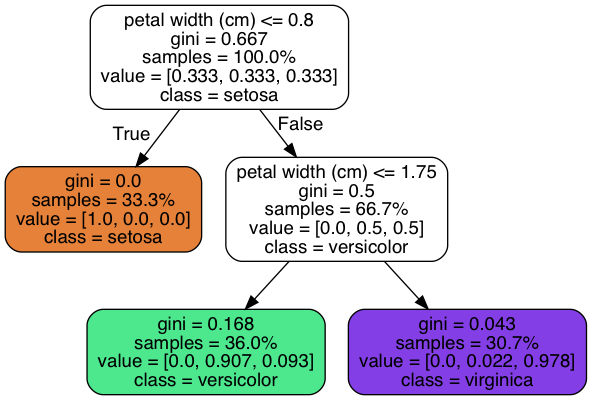

In [141]:
"""References
http://own-search-and-study.xyz/2017/01/08/scikit-learn%E3%81%AE%E6%B1%BA%E5%AE%9A%E6%9C%A8%E3%81%A7%E5%90%84%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%88%B0%E9%81%94%E3%83%8E%E3%83%BC%E3%83%89%E3%82%92%E7%9F%A5%E3%82%8B%E6%96%B9%E6%B3%95/
http://own-search-and-study.xyz/2016/12/25/scikit-learn%E3%81%A7%E5%AD%A6%E7%BF%92%E3%81%97%E3%81%9F%E6%B1%BA%E5%AE%9A%E6%9C%A8%E6%A7%8B%E9%80%A0%E3%81%AE%E5%8F%96%E5%BE%97%E6%96%B9%E6%B3%95%E3%81%BE%E3%81%A8%E3%82%81/
"""

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
  
iris = load_iris()

model = DecisionTreeClassifier(max_depth=2)
model.fit(iris.data, iris.target)

dot_data = StringIO()
export_graphviz(model, 
                out_file=dot_data, 
                feature_names=iris.feature_names,
                class_names=iris.target_names,
                filled=True,
                rounded=True,
                proportion=True,
               )
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [148]:
node_count = model.tree_.node_count
left = model.tree_.children_left
right = model.tree_.children_right
features = [iris.feature_names[i] for i in model.tree_.feature]
value = model.tree_.value
n_node_samples = model.tree_.n_node_samples
threshold = model.tree_.threshold

In [191]:
pd.DataFrame(value[4])

0    1     2
0  0.0  1.0  45.0

In [247]:
def softmax(x):
    """https://gist.github.com/stober/1946926#gistcomment-1445507
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [248]:
pd.DataFrame(softmax(value[4]))

0             1    2
0  2.862519e-20  7.781132e-20  1.0

In [252]:
[round(x, 2) for x in flatten(softmax(value[4]))]

[0.0, 0.0, 1.0]

In [208]:
iris.target_names, softmax(value[4])

(array(['setosa', 'versicolor', 'virginica'],
       dtype='<U10'),
 array([[  2.86251858e-20,   7.78113224e-20,   1.00000000e+00]]))

In [214]:
list(iris.target_names)

['setosa', 'versicolor', 'virginica']

In [217]:
from itertools import chain
from typing import Any, List

def flatten(l: List[Any]) -> List[Any]:
    return list(chain.from_iterable(l))

In [218]:
flatten(softmax(value[4]))

[2.8625185805493937e-20, 7.7811322411337966e-20, 1.0]

In [223]:
pd.DataFrame({
    'target_names': iris.target_names,
    'likelihood': flatten(softmax(value[4])),
}).to_dict(orient='record')

[{'likelihood': 2.8625185805493937e-20, 'target_names': 'setosa'},
 {'likelihood': 7.781132241133797e-20, 'target_names': 'versicolor'},
 {'likelihood': 1.0, 'target_names': 'virginica'}]

In [226]:
def class_name(node):
    return iris.target_names[np.argmax(value[node])]

def class_names(node):
    return pd.DataFrame({
        'target_names': iris.target_names,
        'likelihood': flatten(softmax(value[node])),
    }).to_dict(orient='record')

def generate(node, yes: bool):
    print('-----------------------------------------------------------------------')
    if threshold[node] != -2:  # 葉に続きがある
        print(
            features[node],
            threshold[node],
#             n_node_samples[node],
            class_name(node),
            class_names(node),
        )

#         if left[node] != -1: # 深さ優先なので左隅の葉から攻めていくために再帰させる
#             pass
#         if right[node] != -1: # 深さ優先で左が全部終わったらやっと右の再帰へ
#             pass    
        if yes:
            print('yesyesyes')
            print(generate(left[node], False))
        else:
            print('nonono')
            print(generate(right[node], False))

    else:  # 葉の末端
        print(
#             n_node_samples[node], 
            class_name(node)
        )
        
generate(0, False)

-----------------------------------------------------------------------
petal width (cm) 0.800000011921 setosa [{'target_names': 'setosa', 'likelihood': 0.3333333333333333}, {'target_names': 'versicolor', 'likelihood': 0.3333333333333333}, {'target_names': 'virginica', 'likelihood': 0.3333333333333333}]
nonono
-----------------------------------------------------------------------
petal width (cm) 1.75 versicolor [{'target_names': 'setosa', 'likelihood': 9.643749239819589e-23}, {'target_names': 'versicolor', 'likelihood': 0.5}, {'target_names': 'virginica', 'likelihood': 0.5}]
nonono
-----------------------------------------------------------------------
virginica
None
None


In [263]:
def first_question():
    _node = 0
    return {
        'node': _node,
        'question': {
            'feature': features[_node],
            'threshold': threshold[_node],
        },
        'now_candidates': class_names(_node),
    }


def n_question(node, answer: bool):
    print('-----------------------------------------------------------------------')
    if answer:
        _node = left[node]
    else:
        _node = right[node]
        
    if threshold[_node] == -2:
        question = None
    else:
        question = {
            'feature': features[_node],
            'threshold': threshold[_node],
        }
    return {
        'node': _node,
        'question': question,
        'now_candidates': class_names(_node),
    }

        
n_question(0, True)

-----------------------------------------------------------------------


{'node': 1,
 'now_candidates': [{'likelihood': 1.0, 'target_names': 'setosa'},
  {'likelihood': 1.9287498479639178e-22, 'target_names': 'versicolor'},
  {'likelihood': 1.9287498479639178e-22, 'target_names': 'virginica'}],
 'question': None}

In [264]:
first_question()

{'node': 0,
 'now_candidates': [{'likelihood': 0.3333333333333333,
   'target_names': 'setosa'},
  {'likelihood': 0.3333333333333333, 'target_names': 'versicolor'},
  {'likelihood': 0.3333333333333333, 'target_names': 'virginica'}],
 'question': {'feature': 'petal width (cm)', 'threshold': 0.80000001192092896}}

In [266]:
n_question(0, False)

-----------------------------------------------------------------------


{'node': 2,
 'now_candidates': [{'likelihood': 9.643749239819589e-23,
   'target_names': 'setosa'},
  {'likelihood': 0.5, 'target_names': 'versicolor'},
  {'likelihood': 0.5, 'target_names': 'virginica'}],
 'question': {'feature': 'petal width (cm)', 'threshold': 1.75}}

In [267]:
n_question(2, False)

-----------------------------------------------------------------------


{'node': 4,
 'now_candidates': [{'likelihood': 2.8625185805493937e-20,
   'target_names': 'setosa'},
  {'likelihood': 7.781132241133797e-20, 'target_names': 'versicolor'},
  {'likelihood': 1.0, 'target_names': 'virginica'}],
 'question': None}

In [268]:
n_question(2, True)

-----------------------------------------------------------------------


{'node': 3,
 'now_candidates': [{'likelihood': 5.242885663363464e-22,
   'target_names': 'setosa'},
  {'likelihood': 1.0, 'target_names': 'versicolor'},
  {'likelihood': 7.781132241133797e-20, 'target_names': 'virginica'}],
 'question': None}